# Installing EasyVVUQ

This example is based on https://github.com/vecma-project/VECMA-tutorials/blob/master/EasyVVUQ/Cooling_Cup/EasyVVUQ_Cooling_Cup.ipynb and was updated based on the latest EasyVVUQ interface available at https://github.com/UCL-CCS/EasyVVUQ/blob/dev/tutorials/easyvvuq_pce_tutorial.py

# A Cooling Coffee Cup with Polynomial Chaos Expansion

In this tutorial we will perform a Polynomial Chaos Expansion for a
model of a cooling coffee cup. The model uses Newton's law of cooling to
evolve the temperature, $T$, over time ($t$) in an environment at
$T_{env}$ :

$$\frac{dT(t)}{dt} = -\kappa (T(t) -T_{env})$$

The constant $\kappa$ characterizes the rate at which the coffee cup
transfers heat to the environment. In this example we will analyze this
model using the polynomial chaos expansion (PCE) UQ algorithm. We will
use a constant initial temperature $T_0 = 95 ^\circ\text{C}$, and vary
$\kappa$ and $T_{env}$ using a given probability distribution.

## EasyVVUQ Script Overview

We illustrate the intended workflow using the following basic example
script, a python implementation of the cooling coffee cup model used in
the textit{uncertainpy} documentation (code for which is in the
tests/cooling/ subdirectory of the EasyVVUQ distribution directory). The
code takes a small key/value pair input and outputs a comma separated
value CSV) file.

The input files for this tutorial are the *cooling\_model* application
(`cooling_model.py`), and an input template (`cooling.template`).

In [1]:
import easyvvuq as uq
import chaospy as cp
import numpy as np
import os
from shutil import rmtree

/opt/homebrew/anaconda3/envs/USI_vecma/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Create a new Campaign

We start by creating an
EasyVVUQ Campaign. The Campaign functions as as state machine for the VVUQ workflows. It uses a
database (CampaignDB) to store information on both the target application
and the VVUQ algorithms being employed. It also collects data from the simulations
and can be used to store and resume your state.

In [2]:
work_dir = os.getcwd()
campaign_work_dir = os.path.join(work_dir, "easyvvuq_pce")
# clear the target campaign dir
if os.path.exists(campaign_work_dir):
    rmtree(campaign_work_dir)
os.makedirs(campaign_work_dir)

In [3]:
db_location = "sqlite:///" + campaign_work_dir + "/campaign.db"
my_campaign = uq.Campaign(name='coffee_pce', db_location=db_location, work_dir=campaign_work_dir)
print(my_campaign)

db_location = sqlite:////Users/usi/switchdrive/Institution/usi/PhD/projects/DXT/sensitivity/code/EasyVVUQ-fork/tutorials/correlated/easyvvuq_pce/campaign.db
active_sampler_id = None
campaign_name = coffee_pce
campaign_dir = /Users/usi/switchdrive/Institution/usi/PhD/projects/DXT/sensitivity/code/EasyVVUQ-fork/tutorials/correlated/easyvvuq_pce/coffee_pcerf8q0pws
campaign_id = 1



## Parameter space definition

The parameter space is defined using a dictionary. Each entry in the
dictionary follows the format:

`"parameter_name": {"type" : "<value>", "min": <value>, "max": <value>, "default": <value>}`

With a defined type, minimum and maximum value and default. If the
parameter is not selected to vary in the Sampler (see below) then the
default value is used for every run. In this example, our full parameter
space looks like the following: :

In [4]:
params = {
    "temp_init": {"type": "float", "min": 0.0, "max": 100.0, "default": 95.0},
    "kappa": {"type": "float", "min": 0.0, "max": 0.1, "default": 0.025},
    "t_env": {"type": "float", "min": 0.0, "max": 100.0, "default": 15.0},
    "out_file": {"type": "string", "default": "output.csv"}
}

## App Creation

GenericEncoder is used for substituting values into application template input, which are then used to run the application.

On the other hand, the application output file (in CSV format) is parsed and converted to the EasyVVUQ internal dictionary. The file is parsed in such a way that each column will appear as a vector QoI in the output dictionary.



In [5]:
from pathlib import Path

encoder = uq.encoders.GenericEncoder(
    template_fname="cooling.template",
    delimiter="$",
    target_filename="cooling_in.json"
)

decoder = uq.decoders.SimpleCSV(
    target_filename="output.csv",
    output_columns=["te"]
)

## Define actions

Actions are applied to each relevant run in the database.

In [6]:
execute = uq.actions.ExecuteLocal(
    "python3 {}/cooling_model.py cooling_in.json".format(work_dir)
)

In [7]:
actions = uq.actions.Actions(
    uq.actions.CreateRunDirectory(root=campaign_work_dir, flatten=True),
    uq.actions.Encode(encoder),
    execute,
    uq.actions.Decode(decoder)
)

GenericEncoder performs simple text substitution into a supplied
template, using a specified delimiter to identify where parameters
should be placed. The template is shown below (\$ is used as the
delimiter). The template substitution approach is likely to suit most
simple applications but in practice many large applications have more
complex requirements, for example the multiple input files or the
creation of a directory hierarchy. In such cases, users may write their
own encoders by extending the BaseEncoder class.

As can be inferred from its name SimpleCSV reads CVS files produced by the cooling model code. Again many applications output results in different formats, potentially requiring bespoke Decoders.

```
{
   "T0":"$temp_init",
   "kappa":"$kappa",
   "t_env":"$t_env",
   "out_file":"$out_file"
}
```

## Add the app to the campaign

Having created an encoder, decoder and parameter space definition for our
$cooling$ app, we can add it to our campaign. :

In [8]:
my_campaign.add_app(
    name="cooling",
    params=params,
    actions=actions
)

## The Sampler

The user specified which parameters will vary and their corresponding
distributions. In this case the `kappa` and `t_env` parameters are varied,
both according to a specific distribution:

In [ ]:
# Select distribution of the parameters defined next
params_dist = 'normal_dep' # 'uniform' or 'normal' or 'normal_dep'

In [9]:
# [kappa, t_env]
mu = [0.05, 20]
stddev = [0.008, 1.5]
    
nvar = len(mu)
cov_xy = 0.0048 #0.005 #[0, 0.0024, 0.0048, 0.0072, 0.0096, 0.012] #use the values in order to get corr = range(0,0.2,1)
cov = np.array([[stddev[0]**2,cov_xy], [cov_xy,stddev[1]**2]])
corr = np.array([ [cov[i][j]/(stddev[i]*stddev[j])  for j in range(nvar)]  for i in range(nvar)])

joint = None
if params_dist == 'uniform':
    vary = {
        "kappa": cp.Uniform(0.5*mu[0], 1.5*mu[0]),
        "t_env": cp.Uniform(0.75*mu[1], 1.25*mu[1])
    }
elif params_dist == 'normal':
    vary = {
        "kappa": cp.Normal(mu[0], stddev[0]),
        "t_env": cp.Normal(mu[1], stddev[1])
    }
elif params_dist == 'normal_dep':
    vary = {
        "kappa": cp.Normal(mu[0], stddev[0]),
        "t_env": cp.Normal(mu[1], stddev[1])
    }
    #joint = cp.MvNormal(mu, cov) # will use Rosenblatt
    joint = corr # will use Cholesky transform

To perform a polynomial chaos expansion we will create a PCESampler,
informing it which parameters to vary, and what polynomial rder to use
for the PCE. :

In [11]:
polynomial_order = 3
regression = True
relative_analysis = False

if params_dist == 'normal_dep':
    # Correlated analysis
    my_sampler = uq.sampling.PCESampler(vary=vary, distribution=joint, polynomial_order=polynomial_order, regression=regression, relative_analysis=relative_analysis)
else:
    # Assuming independent parameters
    my_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=polynomial_order, regression=regression, relative_analysis=relative_analysis)

Finally we set the campaign to use this sampler. :

In [12]:
my_campaign.set_sampler(my_sampler)

Calling the campaign's draw\_samples() method will cause the specified
number of samples to be added as runs to the campaign database, awaiting
encoding and execution. If no arguments are passed to draw\_samples()
then all samples will be drawn, unless the sampler is not finite. In
this case PCESampler is finite (produces a finite number of samples) and
we elect to draw all of them at once: :

In [13]:
samples = my_campaign.draw_samples()

In [14]:
kappas = [s['kappa'] for s in samples]
temperatures = [s['t_env'] for s in samples]
print("temperature,kappa")
for s in zip(temperatures, kappas):
    print("%f,%f" % (s[0], s[1]))

temperature,kappa
18.111035,0.055396
17.509977,0.040797
18.723517,0.052549
18.604319,0.047451
19.710762,0.059203
18.301477,0.037727
19.502234,0.051258
19.290205,0.046090
20.284812,0.057097
19.385615,0.042903
20.375363,0.053910
20.153090,0.048742
21.337002,0.062273
19.474513,0.035098
20.825098,0.050627
20.631968,0.045367
21.670350,0.056211
20.861673,0.041920
22.041164,0.053218
22.151337,0.048102


## Execute Runs and Collation

Create a directory hierarchy containing the encoded input files for every run that has not yet been
completed.
Calling `collate()` at any stage causes the campaign to
aggregate decoded simulation output for all runs which have not yet been
collated.

In [15]:
my_campaign.execute().collate()

## Analysis

This collated data is stored in the campaign database. An analysis
element, here PCEAnalysis, can then be applied to the campaign's
collation result. :

In [16]:
# Post-processing analysis
output_columns = ["te"]

my_analysis = uq.analysis.PCEAnalysis(sampler=my_sampler, qoi_cols=output_columns, sampling=True)
my_campaign.apply_analysis(my_analysis)

/opt/homebrew/anaconda3/envs/USI_vecma/lib/python3.9/site-packages/easyvvuq-1.2+41.g3f696f9a-py3.9.egg/easyvvuq/analysis/pce_analysis.py:507: RuntimeWarning: Skipping computation of cp.Corr
  warnings.warn(f"Skipping computation of cp.Corr", RuntimeWarning)
/opt/homebrew/anaconda3/envs/USI_vecma/lib/python3.9/site-packages/easyvvuq-1.2+41.g3f696f9a-py3.9.egg/easyvvuq/analysis/pce_analysis.py:519: RuntimeWarning: Skipping computation of cp.QoI_Dist
  warnings.warn(f"Skipping computation of cp.QoI_Dist", RuntimeWarning)


The output of the analysis can be next queried in order to get detailed statistics:

In [17]:
# Get Descriptive Statistics
results = my_campaign.get_last_analysis()
mean = {}
std = {}
p10 = {}
p90 = {}

sobols_first = {}
derivatives_first = {}
sobols_first_conf = {}
sobols_total = {}

t = np.linspace(0, 200, 150)

for output_column in output_columns:
    mean[output_column] = results.describe("te", "mean")
    std[output_column] = results.describe("te", "std")
    p10[output_column] = results.describe("te", "10%")
    p90[output_column] = results.describe("te", "90%")
    sobols_first[output_column] = {}
    derivatives_first[output_column] = {}
    sobols_total[output_column] = {}    
    for param in vary.keys():
        sobols_first[output_column][param] = results._get_sobols_first(output_column, param)
        #s1_kappa = results._get_sobols_first('te', 'kappa')
        #s1_t_env = results._get_sobols_first('te', 't_env')
        
        #a = np.array(sobols_first[output_column][param])
        #np.savetxt(f'000_{param}.csv', a, delimiter=',')
        
        sobols_total[output_column][param] = results._get_sobols_total(output_column, param)
        #st_kappa = results._get_sobols_total('te', 'kappa')
        #st_t_env = results._get_sobols_total('te', 't_env')
        
        derivatives_first[output_column][param] = results._get_derivatives_first(output_column, param)


#print(f'Mean:\n{mean}')
#print(f'Std:\n{std}')
#print(f'p10:\n{p10}')
#print(f'p90:\n{p90}')

/opt/homebrew/anaconda3/envs/USI_vecma/lib/python3.9/site-packages/easyvvuq-1.2+41.g3f696f9a-py3.9.egg/easyvvuq/analysis/pce_analysis.py:40: RuntimeWarning: In case of the derivative analyis, the final index (in the absolute units of the targed quantities) needs to be scaled by Y(nominal_p)/nominal_p, where the nominal_p is the nominal value of the parameters.
  warnings.warn(f"In case of the derivative analyis, the final index (in the absolute units of the targed quantities) needs to be scaled by Y(nominal_p)/nominal_p, where the nominal_p is the nominal value of the parameters.", RuntimeWarning)


### Data serialization

In [18]:
from serializer import serialize_yaml
from serializer import deserialize_yaml
from joblib import dump, load

data = serialize_yaml(my_campaign=my_campaign,
        output_name= "sobols.yml", output_columns=output_columns,
        params_dist=params_dist, vary=vary,
        mu=mu, stddev=stddev, cov=cov,
        my_sampler=my_sampler, polynomial_order=polynomial_order, regression=regression,
        time=t, mean=mean, variance=std, p10=p10, p90=p90,
        derivatives_first=derivatives_first,
        sobols_first=sobols_first, sobols_total=sobols_total)

# Serialize the surrogate models into a file
filename = campaign_work_dir + "/surrogates.joblib"
dump(results.surrogate(), filename)

/Users/usi/switchdrive/Institution/usi/PhD/projects/DXT/sensitivity/code/EasyVVUQ-fork/tutorials/correlated/easyvvuq_pce/sobols.yml


['/Users/usi/switchdrive/Institution/usi/PhD/projects/DXT/sensitivity/code/EasyVVUQ-fork/tutorials/correlated/easyvvuq_pce/surrogates.joblib']

## Visualization

In [19]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

### PCE Model

In [20]:
# Make data.
Npoints = 80.0
X = np.arange(mu[0]-0.5*mu[0], mu[0]+0.5*mu[0], mu[0]/Npoints)
Y = np.arange(mu[1]-0.25*mu[1], mu[1]+0.25*mu[1], 0.5*mu[1]/Npoints)
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
#Z = np.sin(R)
nx, ny = X.shape
f_surrogate = results.surrogate()
t_idx = list(range(5,t.shape[0],20))
nt = len(t_idx)
Z = np.zeros((nx,ny,nt))
for i in range(nx):
    for j in range(ny):
        #print(f'{X[i,j]}-{Y[i,j]}')
        
        inputs = {"kappa": X[i,j], "t_env": Y[i,j]}
        T = f_surrogate(inputs)[output_column]
        T_ = [T[tt] for tt in t_idx]
        Z[i,j] = T_

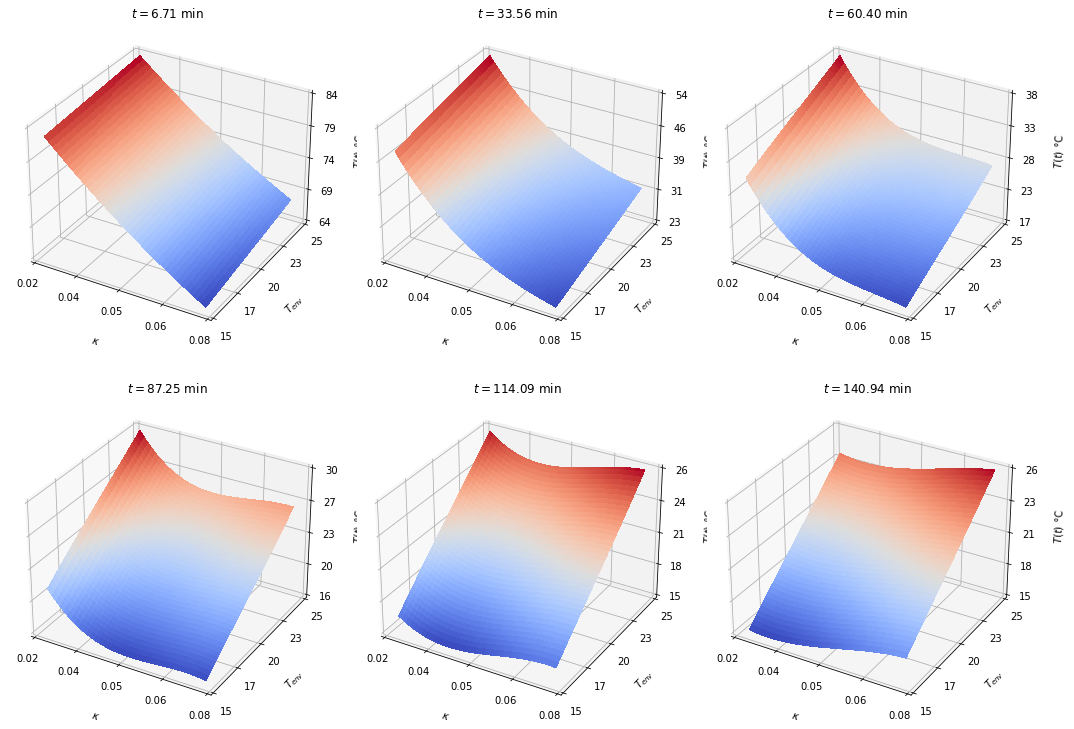

In [21]:
#%matplotlib widget

ncols = 3
nrows = int(nt/ncols)
idx = 1

#figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))
#fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"})

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,11))
output_label = "$T(t)$ °C"
param_labels = {"kappa": "$\kappa$", "t_env":"$T_{env}$"}


for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(nrows, ncols, idx, projection='3d')

        # Plot the surface.
        surf = ax.plot_surface(X, Y, Z[:,:,idx-1], cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)

        # Customize the z axis.
        #ax.set_zlim(-1.01, 1.01)
        ax.xaxis.set_major_locator(LinearLocator(5))
        ax.yaxis.set_major_locator(LinearLocator(5))
        ax.zaxis.set_major_locator(LinearLocator(5))
        # A StrMethodFormatter is used automatically
        ax.xaxis.set_major_formatter('{x:.02f}')
        ax.yaxis.set_major_formatter('{x:.0f}')
        ax.zaxis.set_major_formatter('{x:.0f}')
        plt.xlabel(param_labels["kappa"], labelpad=15)
        plt.ylabel(param_labels["t_env"], labelpad=10)
        ax.set_zlabel(output_label, labelpad=10)
        ax.set_title(f'$t = {t[t_idx[idx-1]]:.2f}$ min', pad=0)

        # Add a color bar which maps values to colors.
        #fig.colorbar(surf, shrink=0.5, aspect=5)
        
        idx = idx + 1

fig.tight_layout(pad=3)
plt.savefig(f'pce_models.pdf', bbox_inches='tight')
plt.show()

### Sensitivity indices

In [22]:
font = {'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

In [23]:
def plot_data(data, method, params, output_column):
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    
    if output_column == "te":
        output_label = "Temperature $T(t)$ °C"
        time_label = ('Time t (min)')
        param_labels = {"kappa": "$\kappa$", "t_env":"$T_{env}$"}
    else:
        output_label = output_column
        time_label = ('Time t (hr)')

    # empty for e.g. SCsampler since this statistic is not supported
    if np.array(data[output_column]["model"]["p10"]).size == 0:
        data[output_column]["model"]["p10"] = np.zeros(len(data[output_column]["model"]["time"]))        
    if np.array(data[output_column]["model"]["p90"]).size == 0:
        data[output_column]["model"]["p90"] = np.zeros(len(data[output_column]["model"]["time"]))
    
    ax1.plot(data[output_column]["model"]["time"], data[output_column]["model"]["mean"], 'g-', alpha=0.75, label='Mean')
    ax1.plot(data[output_column]["model"]["time"], data[output_column]["model"]["p10"], 'b-', alpha=0.25)
    ax1.plot(data[output_column]["model"]["time"], data[output_column]["model"]["p90"], 'b-', alpha=0.25)
    ax1.fill_between(
      data[output_column]["model"]["time"],
      data[output_column]["model"]["p10"],
      data[output_column]["model"]["p90"],
      alpha=0.25,
      label='90% prediction interval')
    ax1.set_xlabel(time_label)
    ax1.set_ylabel(output_label, color='b')
    ax1.tick_params('y', colors='b')
    ax1.legend()

    ax1t = ax1.twinx()
    ax1t.plot(data[output_column]["model"]["time"], data[output_column]["model"]["variance"], 'r-', alpha=0.5, label='Variance')
    ax1t.set_ylabel('Variance', color='r')
    ax1t.tick_params('y', colors='r')
    ax1t.legend(frameon=False)

    ax1.grid()
    ax1.set_title(f'Statistical Moments {method}')
    
    plt.subplots_adjust(wspace=0.35)
    plt.savefig(f'SAmodel_{method}.pdf', bbox_inches='tight')
    plt.show()
    
        
    #################################################################
    has_derivative_analysis = "derivatives_first" in data[output_column][params[0]]
    nrows = 1
    ncols = 2 if has_derivative_analysis else 1
    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))

    idx = 1
    plt.subplot(nrows, ncols, idx)
    
    sum_s1 = np.array(data[output_column][params[0]]["sobols_first"])
    sum_st = np.array(data[output_column][params[0]]["sobols_total"])
    for param in params[1:]:
        sum_s1 = sum_s1 + np.array(data[output_column][param]["sobols_first"])
        sum_st = sum_st + np.array(data[output_column][param]["sobols_total"])
    
    # empty for e.g. SCsampler since this statistic is not supported
    if sum_st.size == 0:
        sum_st = np.zeros(len(data[output_column]["model"]["time"]))
    
    for param in params:
        if output_column == "te":
            param_label = param_labels[param]
        else:
            param_label = param
        plt.plot(data[output_column]["model"]["time"], data[output_column][param]["sobols_first"], label=param_label)
        
    plt.plot(data[output_column]["model"]["time"], sum_s1, '--', label='Sum')
    #plt.plot(data[output_column]["model"]["time"], sum_st, '--', label='Sobol Total Sum')

    plt.xlabel(time_label)
    plt.ylabel('First-order Sobol indices')
    plt.title(f'Variance-based {method}')
    plt.grid(which='both')
    plt.ylim([-0.1, 1.2])
    plt.legend()
    
    ####################################################################
    if has_derivative_analysis:
        idx = idx + 1
        plt.subplot(nrows, ncols, idx)
        for param in params:
            if output_column == "te":
                param_label = param_labels[param]
            else:
                param_label = param
            plt.plot(data[output_column]["model"]["time"], data[output_column][param]["derivatives_first"], label=param_label)
            #plt.semilogy(data[output_column]["model"]["time"], np.abs(data[output_column][param]["derivatives_first"]), label=param_label)

        plt.legend()
        plt.title(f"Derivative-based {method}")
        plt.xlabel(time_label)
        plt.ylabel("Sensitivity index")
        plt.grid(visible=True, which='both')    
    ####################################################################

    figure.tight_layout(pad=3.0)
    plt.savefig(f'SAerror_SobolSum_{method}.pdf', bbox_inches='tight')
    plt.show()

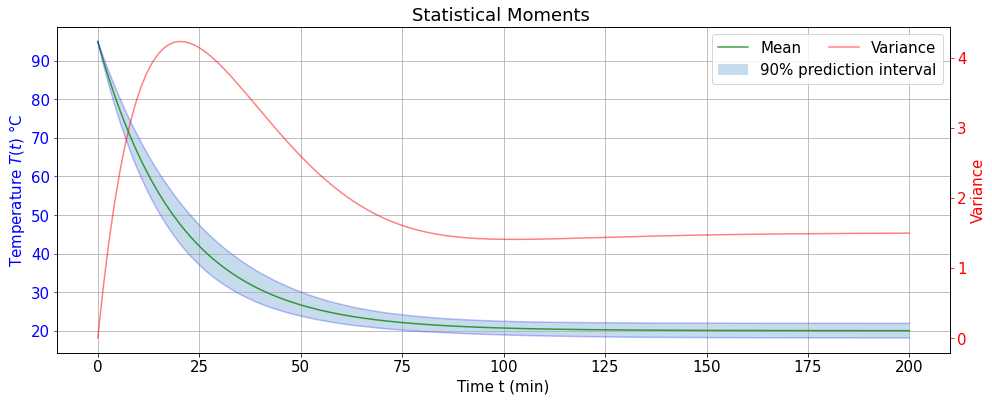

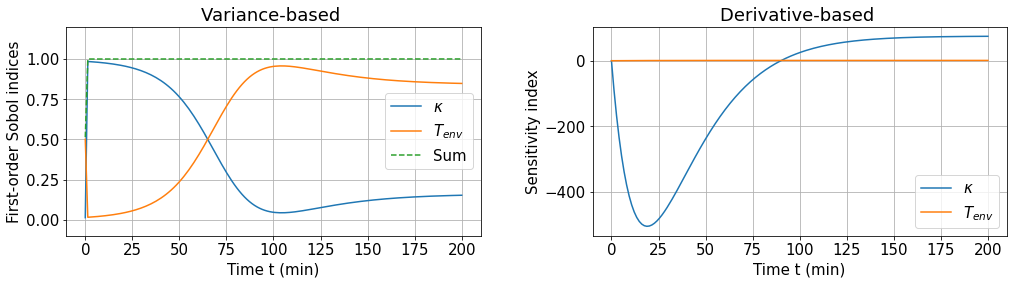

In [24]:
name = ""
params = list(vary.keys())
outputs = output_columns[0]

plot_data(data, name, params , outputs)

In [25]:
def plot_derivatives(data, method, params, output_column):
    
    if output_column == "te":
        output_label = "Temperature $T(t)$ °C"
        time_label = ('Time t (min)')
        param_labels = {"kappa": "$\kappa$", "t_env":"$T_{env}$"}
    else:
        output_label = output_column
        time_label = ('Time t (hr)')
    

    has_derivative_analysis = "derivatives_first" in data[output_column][params[0]]
    nrows = 1
    ncols = 2 if has_derivative_analysis else 1
    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,5))

    
    if has_derivative_analysis:
        idx = 1
        plt.subplot(nrows, ncols, idx)
    
        for param in params:
            if output_column == "te":
                param_label = param_labels[param]
            else:
                param_label = param
            plt.plot(data[output_column]["model"]["time"], data[output_column][param]["derivatives_first"], label=param_label)

        plt.legend()
        plt.title(f"Derivative-based {method} (linear scale)")
        plt.xlabel(time_label)
        plt.ylabel("Sensitivity index")
        plt.grid(visible=True, which='both') 
    
    ####################################################################
    if has_derivative_analysis:
        idx = idx + 1
        plt.subplot(nrows, ncols, idx)
        for param in params:
            if output_column == "te":
                param_label = param_labels[param]
            else:
                param_label = param
            plt.semilogy(data[output_column]["model"]["time"], np.abs(data[output_column][param]["derivatives_first"]), label=param_label)

        plt.legend()
        plt.title(f"Derivative-based {method} (logarithmic scale)")
        plt.xlabel(time_label)
        plt.ylabel("Sensitivity index")
        plt.grid(visible=True, which='both')    
    ####################################################################

    figure.tight_layout(pad=3.0)
    plt.savefig(f'SAerror_derivativesLog_{method}.pdf', bbox_inches='tight')
    plt.show()

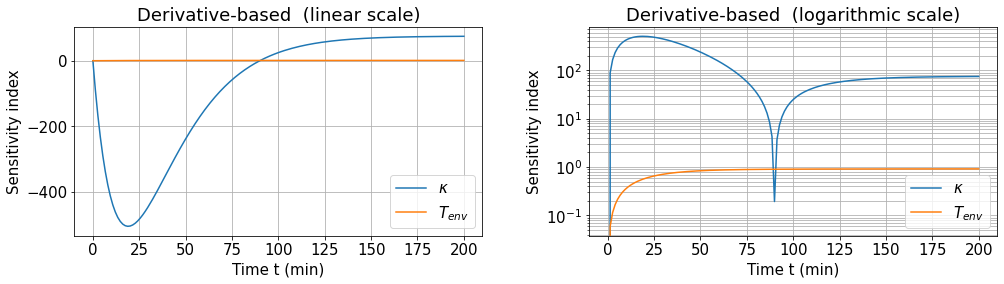

In [26]:
plot_derivatives(data, name, params , outputs)